In [83]:
import numpy as np
import pandas
import gripql
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from scipy.stats import mannwhitneyu, spearmanr
from itertools import combinations

In [3]:
df = pandas.read_csv("results/isoform_real_results.tsv", sep="\t", index_col=0)

In [4]:
lineMapping = pandas.read_csv("real.mapping", sep="\t", index_col=0, header=None, names=["aliquot"])["aliquot"]

In [5]:
df.columns = df.columns.map(lambda x: lineMapping[x.split("|")[0]] + "|" + x.split("|")[1])

In [6]:
lineEntries = {}
for e in df.columns:
    aliquot, entry = e.split("|")
    line = aliquot.split("_")[0]
    if line not in lineEntries:
        lineEntries[line] = { entry : [e] }
    elif entry not in lineEntries[line]:
        lineEntries[line][entry] = [e]
    else:
        lineEntries[line][entry].append(e)

In [7]:
entries = df.columns.map(lambda x: x.split("|")[1]).unique()

In [8]:
conn = gripql.Connection("https://bmeg.io/api", credential_file="../bmeg_credentials.json")

In [9]:
conn.listGraphs()

['bmeg_rc1_3',
 'bmeg_rc1_3__schema__',
 'bmeg_rc2',
 'bmeg_rc3',
 'bmeg_rc2__schema__',
 'rc4',
 'bmeg_rc3__schema__',
 'rc4__schema__',
 'rc5',
 'rc5__schema__']

In [10]:
G = conn.graph("rc5")

In [39]:
q = G.query().V().hasLabel("Transcript").as_("a").out("gene").as_("b").render(["$a._gid", "$b._gid"])

table = {}
for transcript, gene in q:
    if transcript in df.index:
        table[transcript] = gene

[INFO]	2020-04-24 08:58:35,713	214,804 results received in 69 seconds


In [40]:
geneTable = {}
for t,g in table.items():
    if t in df.index:
        if g not in geneTable:
            geneTable[g] = [t]
        else:
            geneTable[g].append(t)

In [41]:
len(table)

196501

In [42]:
transDF = pandas.Series(table)

In [43]:
tc = transDF.value_counts()
tc[tc>=10]

ENSG00000205336    82
ENSG00000165795    78
ENSG00000161249    69
ENSG00000154556    65
ENSG00000178104    63
ENSG00000179818    63
ENSG00000166444    61
ENSG00000169398    59
ENSG00000204580    59
ENSG00000087460    57
ENSG00000236172    55
ENSG00000104529    55
ENSG00000103034    55
ENSG00000237298    52
ENSG00000169045    50
ENSG00000095794    50
ENSG00000065357    49
ENSG00000242086    49
ENSG00000127054    48
ENSG00000197971    48
ENSG00000196628    48
ENSG00000236581    47
ENSG00000079102    47
ENSG00000066427    47
ENSG00000184640    47
ENSG00000204120    47
ENSG00000115677    47
ENSG00000015479    46
ENSG00000099622    46
ENSG00000153113    45
                   ..
ENSG00000118873    10
ENSG00000147679    10
ENSG00000156709    10
ENSG00000164118    10
ENSG00000124788    10
ENSG00000228775    10
ENSG00000214413    10
ENSG00000111799    10
ENSG00000126351    10
ENSG00000133657    10
ENSG00000168028    10
ENSG00000026751    10
ENSG00000086504    10
ENSG00000166704    10
ENSG000001

In [17]:
lineEntries["PC9"]["7150823"]

['PC9_1|7150823',
 'PC9_2|7150823',
 'PC9_3|7150823',
 'PC9_4|7150823',
 'PC9_5|7150823']

In [18]:
entries

Index(['7150823', '7150898', '7185755', '7363252', '7367548', '8023084',
       '8057844', '8064391', '8066038', '8277921', '8277922', '8294423',
       '8473425', '8639678', '8639697', '8639700', '8639902', '8649616',
       '9603865', '9604399', '9604426', '9605357', '9605360', '9607675',
       '9609145', '9609496', '9609497', '9609501', '9609594', '9609644',
       '9610378', '9614357'],
      dtype='object')

In [19]:
aveCorr = {}
for g in geneTable:
    r = {}
    for e in entries:
        x = df.loc[ geneTable[ g ], lineEntries["PC9"][e] ]
        c = list(  spearmanr( x[a], x[b] ).correlation for a,b in combinations(lineEntries["PC9"][e], 2) )
        r[e] = np.mean(c)
    aveCorr[g] = r

/mnt/home/ellrott/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/mnt/home/ellrott/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/mnt/home/ellrott/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/mnt/home/ellrott/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/mnt/home/ellrott/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [20]:
len(aveCorr)

57905

In [21]:
len(geneTable)

57905

In [26]:
aveCorrDF = pandas.DataFrame(aveCorr).drop("9614357")

In [68]:
aveCorrDF.to_csv("real.isoform.ranking_average.tsv", sep="\t")

In [51]:
sub = aveCorrDF.loc[:,tc[tc>=10].index].isnull().sum() == 0

In [103]:
aveCorrDF

,ENSG00000241860,ENSG00000187961,ENSG00000187642,ENSG00000187583,ENSG00000188290,ENSG00000237491,ENSG00000217801,ENSG00000131591,ENSG00000186891,ENSG00000160087,...,ENSG00000249606,ENSG00000217896,ENSG00000260197,ENSG00000225624,ENSG00000227989,ENSG00000228850,ENSG00000225189,ENSG00000223362,ENSG00000232614,ENSG00000234744
7150823,0.880000,0.640000,1.00000,0.788833,1.00,0.835260,0.685714,0.750175,0.887851,0.925557,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7150898,0.880000,0.640000,1.00000,0.788833,1.00,0.835260,0.685714,0.750175,0.887851,0.925557,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7185755,0.814342,0.580000,0.79641,0.505967,0.92,0.598046,0.619788,0.788858,0.679473,0.894021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7363252,0.760000,0.640000,1.00000,0.672144,1.00,0.702199,0.897143,0.773276,0.836228,0.923504,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7367548,0.760000,0.640000,1.00000,0.660000,1.00,0.702199,0.897143,0.773276,0.836228,0.924286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8023084,0.814342,0.640000,0.74641,0.611246,1.00,0.555698,0.497630,0.779534,0.679473,0.811835,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8057844,0.880000,0.640000,1.00000,0.788833,1.00,0.759633,0.651429,0.756224,0.880000,0.923518,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8064391,0.899473,0.580000,0.70000,0.790378,1.00,0.721746,0.655683,0.706087,0.736228,0.903123,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8066038,0.899473,0.580000,0.70000,0.790378,1.00,0.721746,0.655683,0.686177,0.736228,0.903123,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8277921,0.854342,0.520000,0.74641,0.625715,1.00,0.574013,0.712743,0.767789,0.619473,0.812435,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


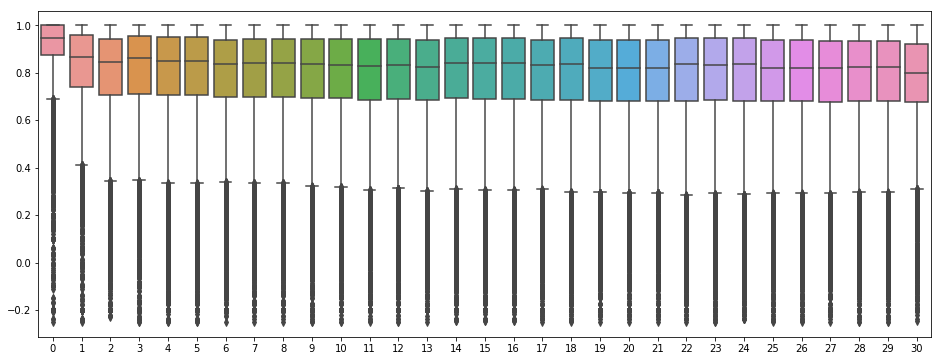

In [106]:
plotOrder = aveCorrDF.mean(axis=1).sort_values(ascending=False).index
plt.figure(figsize=(16, 6))
ax = sns.boxplot( data=list(aveCorrDF.loc[i] for i in plotOrder) )
ax.set_label(plotOrder)

In [107]:
plotOrder

Index(['9609497', '9610378', '8649616', '9604426', '7367548', '7363252',
       '9609644', '8064391', '8066038', '9607675', '9609145', '8023084',
       '9609501', '7185755', '9603865', '7150898', '7150823', '9605357',
       '8473425', '8639678', '8639697', '8639700', '8294423', '9605360',
       '8057844', '8277922', '8277921', '9609496', '8639902', '9609594',
       '9604399'],
      dtype='object')

In [114]:
sub = aveCorrDF.loc[:,tc[ (tc>=10) & (tc <20)].index].isnull().sum() == 0

In [115]:
lineEntries.keys()

dict_keys(['PC9', 'A549', 'JurkatI92', 'HCC1143', 'PC3', 'LNCapFGC'])

In [113]:
len(sub)

5530

In [117]:
aveCorr2 = {}
for g in sub.index:
    r = {}
    for e in entries:
        x = df.loc[ geneTable[ g ], lineEntries["JurkatI92"][e] ]
        c = list(  spearmanr( x[a], x[b] ).correlation for a,b in combinations(lineEntries["JurkatI92"][e], 2) )
        r[e] = np.mean(c)
    aveCorr2[g] = r

/mnt/home/ellrott/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/mnt/home/ellrott/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/mnt/home/ellrott/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/mnt/home/ellrott/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/mnt/home/ellrott/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
